In [1]:
# from data_multi import Bandit_multi
# from learner_diag import NeuralUCBDiag
import numpy as np
import argparse
import pickle
import os
import time
import torch
import numpy as np
from scipy.stats import truncnorm
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 


def truncated_gaussian(mean, variance, a, b, size):
    # Calculate the standard deviation from the variance
    std_dev = np.sqrt(variance)

    # Calculate the lower and upper bounds for truncation
    lower_bound = (a - mean) / std_dev
    upper_bound = (b - mean) / std_dev

    # Generate samples from the truncated normal distribution
    samples = truncnorm.rvs(lower_bound, upper_bound, loc=mean, scale=std_dev, size=size)

    return np.array(samples)

def reshape_context(context, A):
    d = context.shape[0]
    reshaped_context = np.zeros((A, d * A))
    
    for i in range(A):
        start_idx = i * d
        end_idx = start_idx + d
        reshaped_context[i, start_idx:end_idx] = context
    
    return reshaped_context

class Evaluation:

    def __init__(self, game_name, task, n_folds, horizon, game, label, context_type):
        self.game_name = game_name
        self.task = task
        self.n_folds = n_folds
        self.horizon = horizon
        self.game = game
        self.label =  label
        self.context_type = context_type
        

    def get_outcomes(self, game, ):
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        

        context_generator, jobid = job

        np.random.seed(jobid)

        alg.reset(context_generator.d)

        cumRegret =  np.zeros(self.horizon, dtype =float)
        estimates = [ [], [] ]
        compteur = None
        for t in range(self.horizon):
            compteur = t
            if t % 1000 == 0 :
                print(t)

            context,distribution = context_generator.get_context()
            outcome = 0 if distribution[0]>0.5 else 1  #np.random.choice( 2 , p = distribution )

            context = reshape_context(context, alg.A) if alg.name == 'neuralcbpside' else np.reshape(context, (-1,1))
            
            
            action, tdelta = alg.get_action(t, context)

            gap = ( game.LossMatrix[0,...] - game.LossMatrix[1,...])  @ distribution 
            estimates[action].append( (tdelta,gap) )

            print('t', t, 'action', action, 'outcome', outcome, 'gaps', gap )

            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, t, context )

            i_star = np.argmin(  [ game.LossMatrix[i,...] @ np.array( distribution ) for i in range(alg.N) ]  )
            loss_diff = game.LossMatrix[action,...] - game.LossMatrix[i_star,...]
            val = loss_diff @ np.array( distribution )
            cumRegret[t] =  val

        return cumRegret, estimates
    
class ToyContexts:

    def __init__(self, ):
        self.type = 'toy'
        self.d_context = 2

    def get_context(self, ):
        p = np.random.uniform(0, 1)
        return np.array([1,p]), [p, 1-p]


In [6]:
import neuralcbpside_v1
import neuralcbpside_v2
import neuralcbpside_v3
import games
import synthetic_data
import numpy as np
import geometry_v3
import cbpside

horizon = 2500
lbd = 0.1
game = games.apple_tasting( )

size = 5
w = np.array([1/size]*size)
context_generator = synthetic_data.LinearContexts( w,'imbalanced' )

# w = np.array([0,1])
# context_generator = ToyContexts()

alg = neuralcbpside_v3.NeuralCBPside(game, 'theory', 1.01, lbd, 10, 'cuda:0' )
eval2 = Evaluation(None, None, None, horizon, game, None, None)
job2 = context_generator, 0
cumRegret4, estimates = eval2.eval_policy_once(alg, game, job2)

# alg = cbpside.CBPside( game,  1.01, lbd )
# eval1 = Evaluation(None, None, None, horizon, game, None, None)
# job1 = context_generator, 0
# cumRegret1, estimates = eval1.eval_policy_once(alg, game, job1)

0
t 0 action 0 outcome 1 gaps -0.3980454121465575
t 1 action 1 outcome 0 gaps 0.29463651670509994
factor 1.9813369883322334 width [[0.11365355]]
factor 1.9813369883322334 width [[0.10907929]]
estimates [array([[0.21165255]], dtype=float32), array([[0.19873092],
       [0.2334257 ]], dtype=float32)]
pair [0, 1] tdelta 0.034694790840148926 confidence 0.21612283852339242
union1 [0 1]
t 2 action 1 outcome 1 gaps -0.6414578642282047
factor 2.412521913953248 width [[0.09652559]]
factor 2.412521913953248 width [[0.10074317]]
estimates [array([[0.21110457]], dtype=float32), array([[0.21448067],
       [0.2019827 ]], dtype=float32)]
pair [0, 1] tdelta -0.012497961521148682 confidence 0.24304510972497143
union1 [0 1]
t 3 action 1 outcome 0 gaps 0.37825227978457665
factor 2.6710478110477873 width [[0.10004319]]
factor 2.6710478110477873 width [[0.0956294]]
estimates [array([[0.24853499]], dtype=float32), array([[0.2189441],
       [0.1922109]], dtype=float32)]
pair [0, 1] tdelta -0.02673320472240

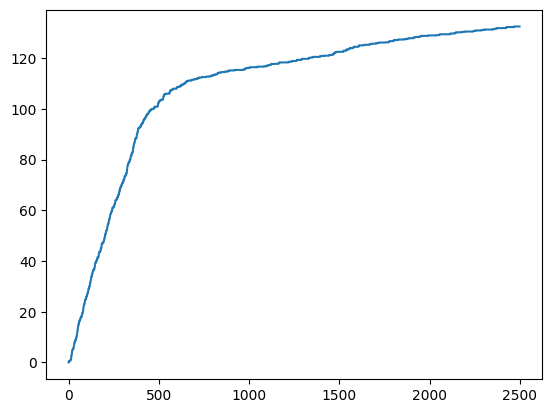

In [7]:
plt.plot( range(horizon) , np.cumsum(cumRegret4) )

ValueError: x and y must have same first dimension, but have shapes (2499,) and (1538,)

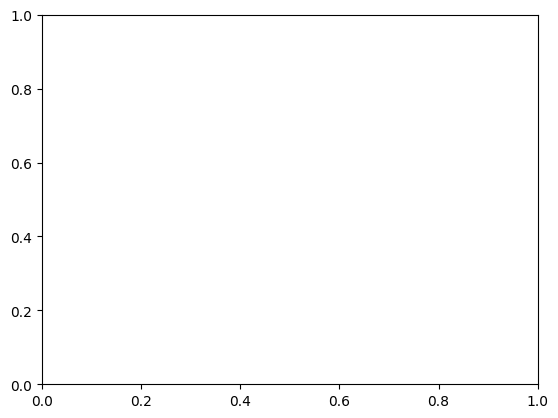

In [4]:
def MSE(y_true, y_pred):

    squared_diff = np.square(y_true - y_pred)

    mse = np.mean(squared_diff)

    return mse


def MAE(y_true, y_pred):

    # Calculate absolute errors
    mae = y_true - y_pred

    return mae


vec = np.array( estimates[1] )
vec1 = np.array( [ MSE(i[1], i[0])   for i in vec ] )
vec2 = np.array( [ MAE(i[1], i[0])   for i in vec ] )

plt.plot( range(1,horizon), vec1 , '.', label = 'MSE')
plt.plot( range(1,horizon), vec2 , '.', label = 'MAE')
plt.legend()
plt.savefig('./NeuralDropout02_{}_{}.png'.format(lbd,horizon))

In [14]:
size = 5
w = np.array([1/size]*size)
context_generator = synthetic_data.LinearContexts( w,'imbalanced' )

features, labels = None, None
features2, labels2 = None, None

for _ in range(10000):

    context,distribution = context_generator.get_context()
    outcome = 0 if distribution[0]>0.5 else 1  #np.random.choice( 2 , p = distribution )
    context1 = reshape_context(context, alg.A) #if alg.name == 'neuralcbpside' else np.reshape(context, (-1,1))
    action = 1
    e_y = np.zeros( (2,1) )
    e_y[outcome] = 1
    Y_t = alg.game.SignalMatricesAdim[action] @ e_y 
    
    features = context1 if features is None else np.concatenate((features, context1), axis=0)
    labels = Y_t if labels is None else np.concatenate((labels, Y_t), axis=0)

    context2 =  np.reshape(context, (-1,1))
    e_y = np.zeros( (2,1) )
    e_y[outcome] = 1
    Y_t2 = alg.game.SignalMatrices[action] @ e_y 
    features2 = context2 if features2 is None else np.concatenate((features2, context2), axis=1)
    features2 = context2 if features2 is None else np.concatenate((features2, context2), axis=1)
    labels2 = Y_t2 if labels2 is None else np.concatenate( (labels2, Y_t2), axis=0)

features2 = features2.T

print( features.shape , labels.shape )
print( features2.shape , labels2.shape )

(30000, 15) (30000, 1)
(20000, 5) (20000, 1)


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the linear regression model
class LinearRegressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressor, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Set the random seed for reproducibility
torch.manual_seed(42)

# Create the model instance
model = LinearRegressor(input_size=15, output_size=1)

# Define the loss function (mean squared error) and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

expected_dtype = next(model.parameters()).dtype

# Training loop
num_epochs = 100
for epoch in range(num_epochs):

    # Forward pass
    outputs = model(torch.tensor( features).to(dtype=expected_dtype) ) 
    
    loss = criterion(outputs, torch.tensor( labels).to(dtype=expected_dtype) )

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
# # Test the model
# test_input = torch.tensor([[5]], dtype=torch.float32)
# predicted_output = model(test_input)
# print(f'Predicted output: {predicted_output.item()}')

Epoch 99, Loss: 0.2094
linear.weight tensor([[ 0.1732,  0.1893, -0.0782,  0.2121, -0.0748,  0.1217, -0.0516,  0.2177,
          0.2925, -0.1141,  0.1221, -0.0504,  0.0901, -0.0623,  0.0237]])
linear.bias tensor([0.2840])


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the linear regression model
class LinearRegressor2(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressor2, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Set the random seed for reproducibility
torch.manual_seed(42)

# Create the model instance
model = LinearRegressor2(input_size=5, output_size=3)

# Define the loss function (mean squared error) and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

expected_dtype = next(model.parameters()).dtype

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(torch.tensor( features2).to(dtype=expected_dtype) ) 
    
    loss = criterion(outputs, torch.tensor( labels2).to(dtype=expected_dtype) )

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
# # Test the model
# test_input = torch.tensor([[5]], dtype=torch.float32)
# predicted_output = model(test_input)
# print(f'Predicted output: {predicted_output.item()}')

Epoch 99, Loss: 0.3363
Epoch 199, Loss: 0.2887
Epoch 299, Loss: 0.2721
Epoch 399, Loss: 0.2650
Epoch 499, Loss: 0.2613
Epoch 599, Loss: 0.2592
Epoch 699, Loss: 0.2578
Epoch 799, Loss: 0.2569
Epoch 899, Loss: 0.2562
Epoch 999, Loss: 0.2557
Epoch 1099, Loss: 0.2553
Epoch 1199, Loss: 0.2550
Epoch 1299, Loss: 0.2547
Epoch 1399, Loss: 0.2545
Epoch 1499, Loss: 0.2542
Epoch 1599, Loss: 0.2540
Epoch 1699, Loss: 0.2538
Epoch 1799, Loss: 0.2537
Epoch 1899, Loss: 0.2535
Epoch 1999, Loss: 0.2533
Epoch 2099, Loss: 0.2532
Epoch 2199, Loss: 0.2530
Epoch 2299, Loss: 0.2529
Epoch 2399, Loss: 0.2528
Epoch 2499, Loss: 0.2527
Epoch 2599, Loss: 0.2525
Epoch 2699, Loss: 0.2524
Epoch 2799, Loss: 0.2523
Epoch 2899, Loss: 0.2522
Epoch 2999, Loss: 0.2521
Epoch 3099, Loss: 0.2520
Epoch 3199, Loss: 0.2519
Epoch 3299, Loss: 0.2518
Epoch 3399, Loss: 0.2518
Epoch 3499, Loss: 0.2517
Epoch 3599, Loss: 0.2516
Epoch 3699, Loss: 0.2515
Epoch 3799, Loss: 0.2515
Epoch 3899, Loss: 0.2514
Epoch 3999, Loss: 0.2513
Epoch 4099,

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the linear regression model
class LinearRegressor(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressor, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Set the random seed for reproducibility
torch.manual_seed(42)

# Create the model instance
model = LinearRegressor(input_size=15, output_size=1)

# Define the loss function (mean squared error) and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

expected_dtype = next(alg.func.parameters()).dtype

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    loss_total = 0
    # Forward pass
    outputs = model(torch.tensor( alg.features).to(dtype=expected_dtype) ) 
    
    loss = criterion(outputs, torch.tensor( alg.labels).to(dtype=expected_dtype) )

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_total += loss.item()
    # Print progress

    print(f'Epoch {epoch}, Loss: {loss_total:.4f}')




for name, param in alg.func.named_parameters():
    if param.requires_grad:
        print(name, param.data)
# # Test the model
# test_input = torch.tensor([[5]], dtype=torch.float32)
# predicted_output = model(test_input)
# print(f'Predicted output: {predicted_output.item()}')

In [3]:
for name, param in alg.func.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[-0.0843,  0.1861, -0.1793, -0.0925, -0.2150, -0.1852, -0.0257,  0.2501,
          0.0843, -0.2009,  0.1305, -0.0431, -0.1203,  0.1378, -0.0096]],
       device='cuda:0')
linear.bias tensor([-0.0869], device='cuda:0')


In [3]:
for name, param in alg.func.named_parameters():
    if param.requires_grad:
        print(name, param.data)

linear.weight tensor([[ 0.0687,  0.1466, -0.1643,  0.0375, -0.1083,  0.3237,  0.3210,  0.5558,
          0.3162,  0.2748, -0.3270, -0.4237, -0.3650, -0.3549, -0.3173]],
       device='cuda:0')
linear.bias tensor([0.3330], device='cuda:0')


In [ ]:
val = []
p = sum(p.numel() for p in list(alg.func.parameters()) ) 
lbd = 0.05
sigma_i = 2
T = 100000
for t in range(1, T):
    v = np.sqrt(  p * np.log(t) + 2 * np.log(1/t**2)   ) + np.sqrt(lbd) * sigma_i 
    val.append(v)
    
plt.plot(range(1, T), val)

In [37]:

import torch
import torch.nn as nn
import torch.optim as optim

# class Network(nn.Module):
#     def __init__(self, output_dim, dim, hidden_size=10):
#         super(Network, self).__init__()
#         self.fc1 = nn.Linear(dim, hidden_size)
#         self.activate = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, output_dim)
#     def forward(self, x):
#         return self.fc2(self.activate(self.fc1(x)))

class Network(nn.Module):
    def __init__(self, output_dim, dim, hidden_size=10):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_size)
        self.activate = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_dim)
        self.sigmoid = nn.Sigmoid( )
    def forward(self, x):
        x = self.fc2(self.activate(self.fc1(x)))
        x = self.sigmoid(x)
        return x

# Create an instance of your model
model = Network(1, 15).cuda()

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1) #, weight_decay=1

length = labels.shape[0]
index = np.arange(length)
np.random.shuffle(index)

epochs = 1000
for epoch in range(epochs):
    running_loss = 0.0
    for i in index:
        input, label = torch.tensor(features[i], dtype=torch.float).cuda() ,  torch.tensor(labels[i], dtype=torch.float).cuda() 
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(input)
        # print(output)
        # loss = nn.MSELoss()(output, label)
        loss = nn.BCELoss()(output, label)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track the loss
        running_loss += loss.item()

    # Print the average loss for the epoch
    print(f"Epoch {epoch + 1} Loss: {running_loss }")

print("Training finished.")

Epoch 1 Loss: 191.61819949746132
Epoch 2 Loss: 171.81261309236288
Epoch 3 Loss: 160.70064198412
Epoch 4 Loss: 151.76865445636213
Epoch 5 Loss: 144.26779567822814
Epoch 6 Loss: 139.35872966982424
Epoch 7 Loss: 135.98660619184375
Epoch 8 Loss: 133.81815046432894
Epoch 9 Loss: 133.40905308397487
Epoch 10 Loss: 129.53546123723208
Epoch 11 Loss: 128.15112248023797
Epoch 12 Loss: 127.52097333655547
Epoch 13 Loss: 127.6262948125077
Epoch 14 Loss: 124.9297045631356
Epoch 15 Loss: 124.34213168322094
Epoch 16 Loss: 125.65422660583954
Epoch 17 Loss: 125.57103053475021
Epoch 18 Loss: 125.53729559366275
Epoch 19 Loss: 124.15089444805108
Epoch 20 Loss: 123.72886606978
Epoch 21 Loss: 123.4920854429688
Epoch 22 Loss: 123.12331012448703
Epoch 23 Loss: 123.13061843031414
Epoch 24 Loss: 123.01522998188307
Epoch 25 Loss: 122.70486598303205
Epoch 26 Loss: 121.8172483319272
Epoch 27 Loss: 121.42813189881213
Epoch 28 Loss: 121.73620852425609
Epoch 29 Loss: 121.6918568751455
Epoch 30 Loss: 121.07351516577205


In [ ]:
# plt.plot(range(horizon), np.cumsum(cumRegret1) )
# plt.plot(range(horizon), np.cumsum(cumRegret2) )
plt.plot(range(horizon), np.cumsum(cumRegret3) )

In [31]:
features = None
labels = None

In [32]:
import numpy as np

class LinearContexts:
    def __init__(self,  w, task):
        self.d = len(w) # number of features
        self.w = w
        self.type = 'linear'
        self.task = task
    
    def get_context(self, ):

        if self.task == 'imbalanced':
            context = truncated_gaussian(0, 0.1, 0, 1, self.d) if np.random.uniform(0,1)<0.5 else truncated_gaussian(1, 0.1, 0, 1, self.d)
        else:
            context = truncated_gaussian(0.5, 1, 0, 1, self.d)
        # cont = context.reshape(self.d,1)
        p = self.w @ context
        val = [ p, 1-p ]
        context = context - np.ones(5) * 0.5
        context = context.astype(np.float64)
        return context , val 

A = 3
size = 5
w = np.array([1/size]*size)
context_generator = LinearContexts(w, 'imbalanced')

for _ in range(100):
    c,d = context_generator.get_context()
    print(d)
    c = reshape_context(c, A)

    e_y = np.zeros( A )
    outcome = 0 if d[0]<0.5 else 1
    action = np.random.randint(2)
    if action == 0:
        e_y[-1] = 1
    else:
        e_y[outcome] = 1
    print(e_y)
    Y_t = e_y.reshape(A,1)
    features = c if features is None else np.concatenate((features, c), axis=0)
    labels = Y_t if labels is None else np.concatenate((labels, Y_t), axis=0)


[0.781837598653284, 0.21816240134671605]
[0. 1. 0.]
[0.6556621380150109, 0.34433786198498906]
[0. 0. 1.]
[0.7789886507633803, 0.2210113492366197]
[0. 1. 0.]
[0.6950717806433822, 0.30492821935661785]
[0. 0. 1.]
[0.2905294738750467, 0.7094705261249533]
[0. 0. 1.]
[0.7637702218739297, 0.23622977812607027]
[0. 0. 1.]
[0.2930578692126846, 0.7069421307873154]
[0. 0. 1.]
[0.8009125498861533, 0.19908745011384665]
[0. 0. 1.]
[0.7022237121316804, 0.29777628786831956]
[0. 0. 1.]
[0.838445309974184, 0.16155469002581602]
[0. 1. 0.]
[0.8483303844579365, 0.15166961554206349]
[0. 1. 0.]
[0.37632054322920316, 0.6236794567707968]
[1. 0. 0.]
[0.81904645005698, 0.18095354994302004]
[0. 1. 0.]
[0.11547315940506402, 0.884526840594936]
[0. 0. 1.]
[0.20238851634306218, 0.7976114836569378]
[1. 0. 0.]
[0.16724887449258274, 0.8327511255074173]
[1. 0. 0.]
[0.276104891987722, 0.723895108012278]
[1. 0. 0.]
[0.6470652508863118, 0.35293474911368816]
[0. 1. 0.]
[0.7852475857655943, 0.21475241423440572]
[0. 0. 1.]
[0.7

In [33]:
d = 10
sigma_i = 2
lbd = 0.05
value1, value2, value3, value4 = [], [], [], []
for t in range(1, 10000):
    value1.append(  d * (  np.sqrt(  d * np.log(t) + 2 * np.log(1/t**2)   ) + 2 ) )
    value2.append(  d * (  np.sqrt(  (d+1) * np.log(t)   ) + 2 ) )
    value3.append(  sigma_i * (  np.sqrt(  d * np.log(t) + 2 * np.log(1/t**2)   ) +  sigma_i ) )
    value4.append(  sigma_i * (  np.sqrt(  d * np.log(t) + 2 * np.log(1/t**2)   ) + np.sqrt(lbd) * sigma_i ) )

plt.plot( range(9999), value1, label = 'width1')
plt.plot( range(9999), value2, label = 'width2')
plt.plot( range(9999), value3, label = 'width3')
plt.plot( range(9999), value4, label = 'width4')
plt.legend()

p = 435
sigma_i = 2
lbd = 0.05
value3, value4 = [], []
for t in range(1, 10000):
    value3.append(  sigma_i * (  np.sqrt(  p * np.log(t) + 2 * np.log(1/t**2)   ) +  sigma_i ) )
    value4.append(  sigma_i * (  np.sqrt(  p * np.log(t) + 2 * np.log(1/t**2)   ) + np.sqrt(lbd) * sigma_i ) )

plt.plot( range(9999), value3, label = 'width3')
plt.plot( range(9999), value4, label = 'width4')
plt.legend()

size = 10
w = np.array([1/size]*size)
context_generator = synthetic_data.LinearContexts( w,'balanced' )

dis = []
for _ in range(1000):
    c,d = context_generator.get_context()
    dis.append(d[0])

plt.hist(dis, bins=30, density=True, alpha=0.7)